In [33]:
import atlite
import matplotlib.pyplot as plt
from scipy.ndimage import label
import math 
import numpy as np
import json 
import pickle
import os 
import geopandas as gpd
from rasterio.plot import show  
from atlite.gis import shape_availability
import rasterio
from rasterio.transform import Affine
import yaml
from unidecode import unidecode

dirname = os.getcwd() 
#main_dir = os.path.join(dirname, '..')
with open(os.path.join("configs/config.yaml"), "r", encoding="utf-8") as f:
    config = yaml.load(f, Loader=yaml.FullLoader) 

In [27]:
region_name = config['region_name'] #if country is studied, then use country name
region_name_clean = unidecode(region_name)
region_name_clean = region_name_clean.replace(" ", "")
region_name_clean = region_name_clean.replace(".", "")
region_name_clean = region_name_clean.replace("'", "") 
region_name = region_name_clean
region_folder_name = config['region_folder_name']

resampled = '_resampled' 

EPSG_custom = config['EPSG_manual']


dirname = os.getcwd() 
data_path = os.path.join(dirname, 'data', region_folder_name)
data_from_DEM = os.path.join(data_path, 'derived_from_DEM')

# Load the json EPSG code for the country
with open(os.path.join(data_path, region_name+'_EPSG.pkl'), 'rb') as file:
        EPSG = pickle.load(file)
#use custom EPSG instead of local UTM zone if wanted
if EPSG_custom:
    EPSG=int(EPSG_custom)

print(f'EPSG {EPSG}')


#path to file and check if it exists and save 1 or 0 for later
landcoverPath=os.path.join(data_path, f'landcover_{region_name}_EPSG{EPSG}.tif')
landcover=0 if not os.path.isfile(landcoverPath) and print('no landcover file') is None else 1
demRasterPath = os.path.join(data_path, f'DEM_{region_name}_EPSG{EPSG}{resampled}.tif')
dem=0 if not os.path.isfile(demRasterPath) and print('no DEM file') is None else 1
slopeRasterPath = os.path.join(data_from_DEM, f'slope_{region_name}_EPSG{EPSG}{resampled}.tif')
slope=0 if not os.path.isfile(slopeRasterPath) and print('no slope file') is None else 1

regionPath =os.path.join(data_path, f'{region_name}_{EPSG}.geojson')
region = gpd.read_file(regionPath)

northfacingRasterPath = os.path.join(data_from_DEM, f'north_facing_{region_name}_EPSG{EPSG}{resampled}.tif')
nfacing=0 if not os.path.isfile(northfacingRasterPath) and print('no north facing pixels file') is None else 1
coastlinesPath = os.path.join(data_path, f'goas_{region_name}_{EPSG}.gpkg')
coastlines=0 if not os.path.isfile(coastlinesPath) and print('no coastlines file') is None else 1
protectedAreasPath = os.path.join(data_path, f'protected_areas_{region_name}_{EPSG}.gpkg')
protectedAreas=0 if not os.path.isfile(protectedAreasPath) and print('no protected areas file') is None else 1
#OSM
roadsPath = os.path.join(data_path, f'OSM_roads_{region_name}_{EPSG}.gpkg')
roads=0 if not os.path.isfile(roadsPath) and print('no roads file') is None else 1
railwaysPath = os.path.join(data_path, f'OSM_railways_{region_name}_{EPSG}.gpkg')
railways=0 if not os.path.isfile(railwaysPath) and print('no railways file') is None else 1
airportsPath = os.path.join(data_path, f'OSM_airports_{region_name}_{EPSG}.gpkg')
airports=0 if not os.path.isfile(airportsPath) and print('no airports file') is None else 1
waterbodiesPath = os.path.join(data_path, f'OSM_waterbodies_{region_name}_{EPSG}.gpkg')
waterbodies=0 if not os.path.isfile(waterbodiesPath) and print('no waterbodies file') is None else 1

EPSG 32632


In [28]:
#load unique land use codes
with open(os.path.join(data_path, f'landuses_{region_name}.json'), 'r') as fp:
    landuses = json.load(fp)

#load pixel size
if not EPSG==4326:
    with open(os.path.join(data_path, f'pixel_size_{region_name}_{EPSG}.json'), 'r') as fp:
        res = json.load(fp)
else:
    res = 0.0009920634920634887558 #???? res for 4326

#load landcover transform
with open(os.path.join(data_path, f'transform_landcover_{region_name}_{EPSG}.json'), 'r') as fp:
    transform_landcover = json.load(fp)
transform_landcover = Affine(*transform_landcover)

print(landuses)
print(len(landuses))
print(res)
transform_landcover

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
11
7.996486664760652


Affine(7.996486664760652, 0.0, 308818.6038033755,
       0.0, -7.996486664760656, 4915376.217967398)

In [6]:
region.geometry.item().area/1e6 #km²

4320.5052058849105

# Set your exclusions

In [34]:
#raster can be in different CRS than exclusioncontainer, it is co-registered by atlite!
#vector data needs to be in CRS of exclusioncontainer???

#initiate Exclusion container
excluder = atlite.ExclusionContainer(crs=EPSG, res=res)

#add landcover exclusions
excluder.add_raster(landcoverPath, codes=config['landcover_without_buffer'],crs=EPSG)
for key, value in config['landcover_with_buffer'].items():
    excluder.add_raster(landcoverPath, codes=key, buffer=value ,crs=EPSG)

#add elevation exclusions
if dem==1: excluder.add_raster(demRasterPath, codes=range(config['max_elevation'],10000), crs=EPSG)

#add slope exclusions
if slope==1: excluder.add_raster(slopeRasterPath, codes=range(config['max_slope'],90), crs=EPSG)

#add north facing exclusion
if nfacing==1: excluder.add_raster(northfacingRasterPath, codes=1, crs=EPSG)


#add exclusions from vector data
if railways==1: excluder.add_geometry(railwaysPath, buffer=config['railways_buffer'])
if roads==1: excluder.add_geometry(roadsPath, buffer=config['roads_buffer'])
if airports==1: excluder.add_geometry(airportsPath, buffer=config['airports_buffer'])
if waterbodies==1: excluder.add_geometry(waterbodiesPath, buffer=config['waterbodies_buffer'])
if coastlines==1: excluder.add_geometry(coastlinesPath, buffer=config['coastlines_buffer'])
if protectedAreas==1: excluder.add_geometry(protectedAreasPath, buffer=config['protectedAreas_buffer'])

#calculate available areas
masked, transform = shape_availability(region.geometry, excluder)

eligible_share = masked.sum() * excluder.res**2 / region.geometry.item().area
print(f"The eligibility share is: {eligible_share:.2%}")

The eligibility share is: 6.76%


<Axes: title={'center': 'Eligible area (green) 3.78%'}>

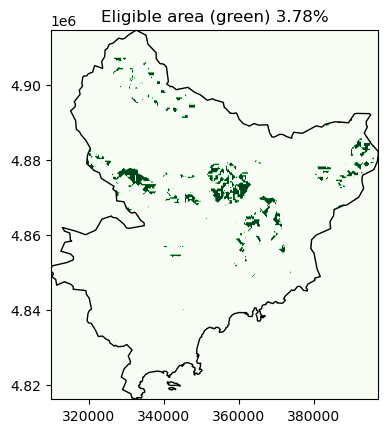

In [23]:
fig, ax = plt.subplots()
excluder.plot_shape_availability(region)

In [9]:
#area filter
def area_filter(boolean_array, min_size=5):
    # Label connected components in the array
    labeled_array, num_features = label(boolean_array)
    
    # Count the number of pixels in each component
    component_sizes = np.bincount(labeled_array.ravel())
    
    # Create a mask for components that meet the size requirement (ignoring the background)
    large_component_mask = np.zeros_like(component_sizes, dtype=bool)
    large_component_mask[1:] = component_sizes[1:] >= min_size  # Skip the background component (index 0)
    
    # Filter the original array, keeping only large components
    filtered_array = large_component_mask[labeled_array]
    
    return filtered_array

In [10]:
masked_area_filtered = area_filter(masked,config['min_pixels_connected'])

#array to be used 
array = masked_area_filtered

# Convert boolean array to integers (1 for True, 0 for False)
int_array = array.astype(np.uint8)

# Set 0 (False) to be the nodata value
nodata_value = 0

#save eligible land array as .tif file
# Define the metadata for the new file
# You'll need to adjust these parameters based on your specific data
metadata = {
    'driver': 'GTiff',
    'dtype': rasterio.uint8,
    'nodata': nodata_value,
    'width': array.shape[1],
    'height': array.shape[0],
    'count': 1,
    'crs': rasterio.crs.CRS.from_epsg(EPSG),  # WGS84, modify as needed
    'transform': transform,
    'compress': 'LZW' 
}

# Write the array to a new .tif file
if masked_area_filtered in array:
    with rasterio.open(os.path.join(data_path, f'available_land_filtered-min{min_pixels_connected}_{region_name}_EPSG{EPSG}.tif'), 'w', **metadata) as dst:
        dst.write(array, 1)
else:
    with rasterio.open(os.path.join(data_path, f'available_land_total_{region_name}_EPSG{EPSG}.tif'), 'w', **metadata) as dst:
        dst.write(array, 1)    